# ML Project 1 : Group 14

This notebook houses code for anomaly detection using Orion-ML. Orion is a `python` package for time series anoamly detection. We will use TadGAN model, and perform anomaly detection. 

### Import Pacakges

In [1]:
pip install orion-ml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec

from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from orion.data import load_signal, load_anomalies
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from utils import time_segments_aggregate, rolling_window_sequences,compute_intervals, evaluate

### Utility Functions

In [3]:
# -*- coding: utf-8 -*-
np.random.seed(0)

def unroll_ts(y_hat):
    predictions = list()
    pred_length = y_hat.shape[1]
    num_errors = y_hat.shape[1] + (y_hat.shape[0] - 1)

    for i in range(num_errors):
            intermediate = []

            for j in range(max(0, i - num_errors + pred_length), min(i + 1, pred_length)):
                intermediate.append(y_hat[i - j, j])

            if intermediate:
                predictions.append(np.median(np.asarray(intermediate)))

    return np.asarray(predictions[pred_length-1:])

def convert_date(timelist):
    converted = list()
    for x in timelist:
        converted.append(datetime.fromtimestamp(x))
    return converted

def convert_date_single(x):
    return datetime.fromtimestamp(x)

def plot_error(X):
    plt.figure(figsize = (30, 6))
    gs1 = gridspec.GridSpec(3, 1)
    gs1.update(wspace=0.025, hspace=0.05) 

    i = 0
    for x in X:
        if len(x) == 2:
            ax1 = plt.subplot(gs1[i:i+2])
            for line in x:
                t = range(len(line))
                ax1.plot(t, line)
            i+=1
        else:
            ax1 = plt.subplot(gs1[i])
            t = range(len(line))
            ax1.plot(t, x, color='tab:red')

        i+=1
        plt.xlim(t[0], t[-1])
        plt.yticks(size=22)
        plt.axis('on')
        ax1.set_xticklabels([])

    plt.show()


def plot(dfs, anomalies=[]):
    """ Line plot for time series.
    
    This function plots time series and highlights anomalous regions.
    The first anomaly in anomalies is considered the ground truth.
    
    Args:
        dfs (list or `pd.DataFrame`): List of time series in `pd.DataFrame`.
            Or a single dataframe. All dataframes must have the same shape.
        anomalies (list): List of anomalies in tuple format.
    """    
    if isinstance(dfs, pd.DataFrame):
        dfs = [dfs]
        
    if not isinstance(anomalies, list):
        anomalies = [anomalies]
        
    df = dfs[0]
    time = convert_date(df['timestamp'])
    months = mdates.MonthLocator()  # every month
    days = mdates.DayLocator() # every day

    month_fmt = mdates.DateFormatter('%b')

    fig = plt.figure(figsize=(30, 6))
    ax = fig.add_subplot(111)

    for df in dfs:
        plt.plot(time, df['value'])

    colors = ['red'] + ['green'] * (len(anomalies) - 1)
    for i, anomaly in enumerate(anomalies):
        if not isinstance(anomaly, list):
            anomaly = list(anomaly[['start', 'end']].itertuples(index=False))
        
        for _, anom in enumerate(anomaly):
            t1 = convert_date_single(anom[0])
            t2 = convert_date_single(anom[1])
            plt.axvspan(t1, t2, color=colors[i], alpha=0.2)

    plt.title('NYC Taxi Demand', size=34)
    plt.ylabel('# passengers', size=30)
    plt.xlabel('Time', size=30)
    plt.xticks(size=26)
    plt.yticks(size=26)
    plt.xlim([time[0], time[-1]])

    # format xticks
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(month_fmt)
    ax.xaxis.set_minor_locator(days)
    
    # format yticks
    ylabels = ['{:,.0f}'.format(x) + 'K' for x in ax.get_yticks()/1000]
    ax.set_yticklabels(ylabels)
    
    plt.show()
    
    
def plot_rws(X, window=100, k=5, lim=1000):
    shift = 75
    X = X[window:]
    t = range(len(X))
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    
    num_figs = int(np.ceil(k / 5)) + 1
    fig = plt.figure(figsize=(15, num_figs * 2))
    
    j = 0
    ax = fig.add_subplot(num_figs, 5, j+1)
    idx = t[j: window + j]
    ax.plot(idx, X[j], lw=2, color=colors[j])
    plt.title("window %d" % j, size=16)
    plt.ylim([-1, 1])
    
    j = 1
    ax = fig.add_subplot(num_figs, 5, j+1)
    idx = t[j: window + j]
    ax.plot(idx, X[j], lw=2, color=colors[j])
    ax.set_yticklabels([])
    plt.title("window %d" % j, size=16)
    plt.ylim([-1, 1])
        
    for i in range(2, k):
        j = i * shift
        idx = t[j: window + j]
        
        ax = fig.add_subplot(num_figs, 5, i+1)
        ax.plot(idx, X[j], lw=2, color=colors[i+1])
        ax.set_yticklabels([])
        plt.title("window %d" % j, size=16)
        plt.ylim([-1, 1])
    
    plt.tight_layout()
    plt.show()

---

# Part 1:Data Loading

In [4]:
data = pd.read_csv("SKAB.csv")

In [5]:
data.head()

,timestamp,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS
0,1583772991,0.027495,0.039593,0.939237,0.054711,69.1741,24.1655,238.008,32.0000
1,1583772992,0.027394,0.040137,1.235540,0.054711,69.0063,24.1664,229.409,32.0000
2,1583772993,0.027292,0.040152,1.331430,0.054711,69.0291,24.1567,241.450,32.0000
3,1583772994,0.027325,0.038464,1.256480,-0.273216,68.9928,24.1582,250.288,32.0431
4,1583772995,0.027303,0.036969,1.355950,0.054711,68.9590,24.1562,240.265,32.9581


## Part 2

In part two of the series, we look at anomaly detection through time series reconstruction, particularly using a TadGAN model. We go through a sequence of transformations and data preparation, as well as model training and prediction. 
We have used `Orion` to perform these sequence of actions. We will be emphasizing the usage of the `TadGAN` model which is a time series anomaly detection using GANs model.

### Data Preparation 
#### A. data frequency
Adjust signal spacing to be of equal width across all times. There are two important parameters in this process:
- interval: an interger that refers to the time span to compute aggregation of.
- method: what aggregation method should be used to compute the value, by default this set to the mean.

In addition to, passing the array of values and which column holds the values we wish to alter the frequency of.

In [7]:
X, index = time_segments_aggregate(data, interval=1, time_column='timestamp')

In our example the data is perfectly spaced, so we can skip this preprocessing step. However, that is not always the case and so we include it as a preprocessing primitive in the general pipeline as you will see later on.

#### B. data imputation

impute missing values that appear within the signal using scikit-learn's `SimpleImputer` which fills missing values by the mean value.

In [8]:
imp = SimpleImputer()
X = imp.fit_transform(X)

#### C. data normalization 
normalize the data between a specific range, we use scikit-learn's `MinMaxScaler` to scale data between [-1, 1].

In [9]:
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)

#### D. slice the data to rolling window
to prepare the data, we need to transform it into a sequence that is ingestable by the machine learning model. 
We take the signal we're interested in analyzing and we generate training examples. These training examples are mere snapshots of signal at different times.

In order to do that, we adopt the sliding window approach of choosing a window of a pre-specified width and a particular step size. Once that's been decided we divide the signal indo segments, similar to what is depicited in the illustration below.

We create a `rolling_window_sequence` function that slices the data into parts, each part contains:
- the target value; the value at time t.
- previous observed values, this is determined by the window width.

In [10]:
X, y, X_index, y_index = rolling_window_sequences(X, index, window_size=100,target_size=1, step_size=1,target_column=0)

In [11]:
print("Training data input shape: {}".format(X.shape))
print("Training data index shape: {}".format(X_index.shape))
print("Training y shape: {}".format(y.shape))
print("Training y index shape: {}".format(y_index.shape))

Training data input shape: (959, 100, 8)
Training data index shape: (959,)
Training y shape: (959, 1)
Training y index shape: (959,)


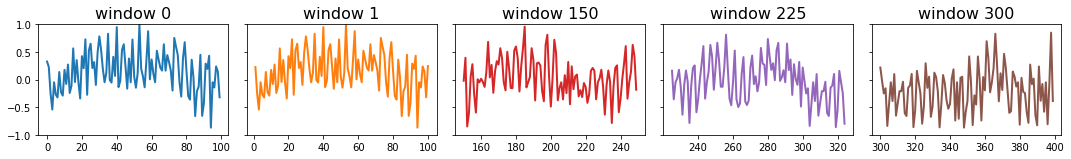

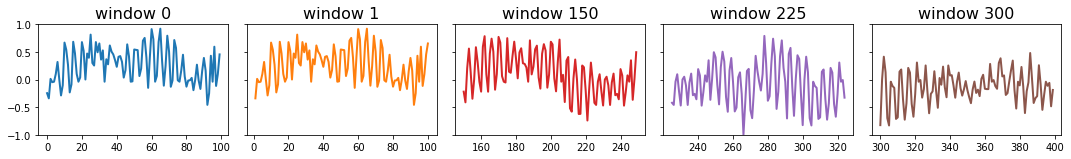

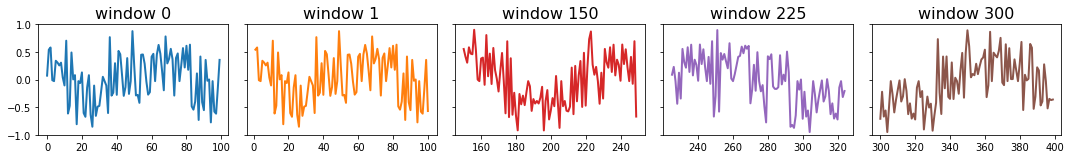

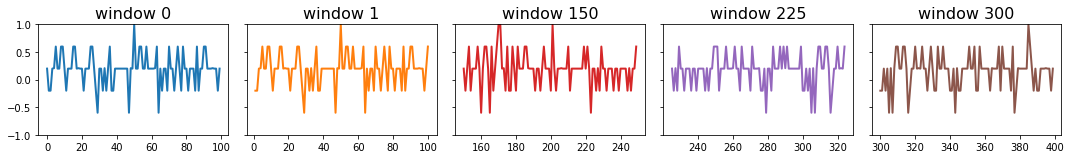

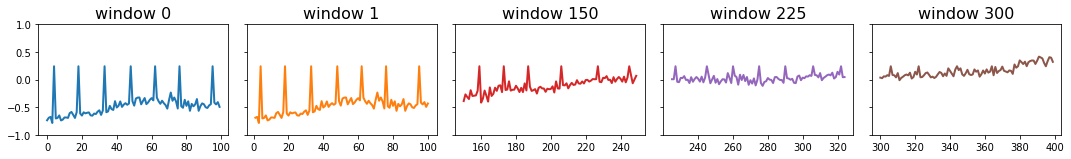

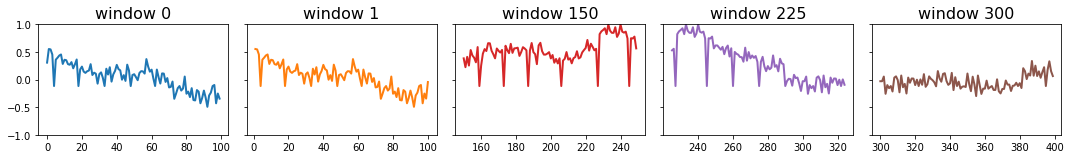

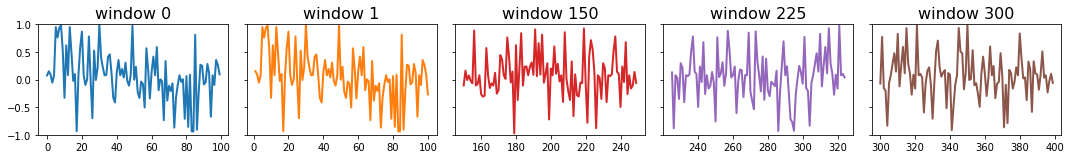

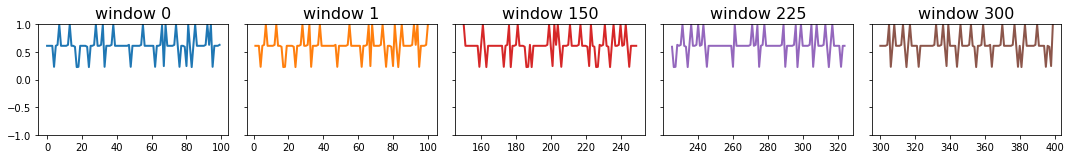

In [12]:
for i in range(X.shape[2]):
  plot_rws(X[:,:,i])

### Pipeline Training and Detection

The architecture of the model requires four neural networks:
- `encoder`: maps `X` to its latent representation `Z`.
- `generator`: maps the latent variable `Z` back to `X`, which we will denote later on as `X_hat`.
- `criticX`: discriminates between `X` and `generator(Z)` or `X_hat`.
- `criticZ`: discriminates between `Z` and `encoder(X)`.

we detail the composition of each network in `model.py`.

To use the `TadGAN` model, we specify a number of parameters including the model layers (structure of the previously mentioned neural networks). We also specify the input dimensions, the number of epochs, the learning rate, etc. All the parameters are listed below.

In [ ]:
from model import hyperparameters
from orion.primitives.tadgan import TadGAN

hyperparameters["epochs"] = 10
hyperparameters["input_shape"] = (100, 8) # based on the window size
hyperparameters["target_shape"] = (100, 1) # based on the window size
hyperparameters["optimizer"] = "keras.optimizers.Adam"
hyperparameters["learning_rate"] = 0.0005
hyperparameters["latent_dim"] = 20
hyperparameters["batch_size"] = 64
channel = 0 # index of channel to reconstruct
y = X[:, :, channel:channel+1] # slice it out of X
tgan = TadGAN(**hyperparameters)
tgan.fit(X, y)

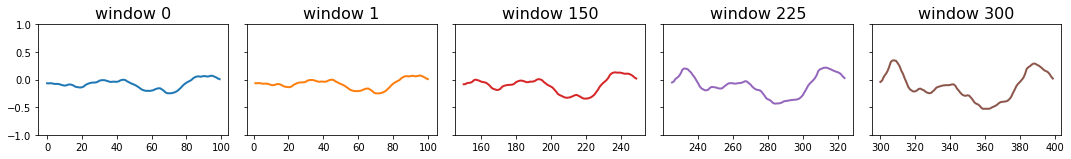

In [14]:
# reconstruct
X_hat, critic = tgan.predict(X,y)
# visualize X_hat
plot_rws(X_hat)

To reassemble or “unroll” the predicted signal `X_hat` we can choose different aggregation methods (e.g., mean, max, etc). In our implementation, we chose it to as the median value.

In [15]:
def unroll_ts(y_hat):
    predictions = list()
    pred_length = y_hat.shape[1]
    num_errors = y_hat.shape[1] + (y_hat.shape[0] - 1)

    for i in range(num_errors):
            intermediate = []

            for j in range(max(0, i - num_errors + pred_length), min(i + 1, pred_length)):
                intermediate.append(y_hat[i - j, j])

            if intermediate:
                predictions.append(np.median(np.asarray(intermediate)))

    return np.asarray(predictions[pred_length-1:])


In [16]:
y_hat = unroll_ts(X_hat)

In [18]:
y = data.iloc[:,1].to_numpy()

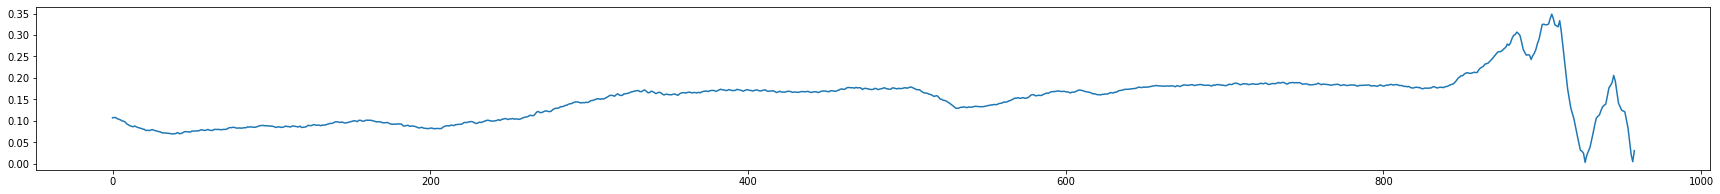

In [20]:
# pair-wise error calculation
error = np.zeros(shape=y_hat.shape)
length = y_hat.shape[0]
for i in range(length):
    error[i] = abs(y_hat[i] - y[i])
# visualize the error curve
fig = plt.figure(figsize=(30, 3))
plt.plot(error)
plt.show()

### Error Computation

In the `TadGAN` pipeline, we use `tadgan.score_anomalies` to perform error calculation for us. It is a smoothed error function that uses a window based method to smooth the curve then uses either: area, point difference, or dtw as a measure of discrepancy. 

#### Area
This method captures the general shape of the orignal and reconstructed signal and then compares them together. 

#### Point
This method applies a point-to-point comparison between the original and reconstructed signal. It is considered a strict approach that does not allow for many mistakes.

#### DTW
A more lenient method yet very effective is Dynamic Time Warping (DTW). It compares two signals together using any pair-wise distance measure but it allows for one signal to be lagging behind another.


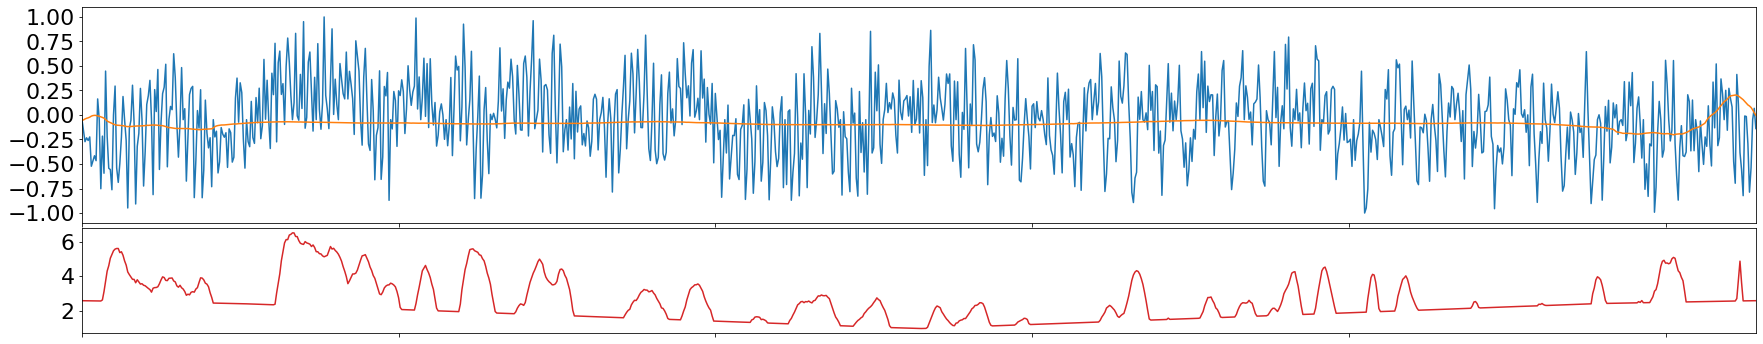

In [21]:
from orion.primitives.tadgan import score_anomalies

error, true_index, true, pred = score_anomalies(X[:,:,[0]], X_hat, X_index, critic, rec_error_type="dtw", comb="mult")
pred = np.array(pred).mean(axis=2)

# visualize the error curve
plot_error([[true, pred], error])

In [22]:
# threshold
thresh = 3
intervals = list()
i = 0
max_start = len(error)
while i < max_start:
    j = i
    start = index[i]
    while i < len(error) and error[i] > thresh:
        i += 1
    end = index[i]
    if start != end:
        intervals.append((start, end, np.mean(error[j: i+1])))
    i += 1
intervals

[(1583773005, 1583773057, 3.9698951359527768),
 (1583773060, 1583773073, 3.401067576352613),
 (1583773114, 1583773179, 5.0816893193782935),
 (1583773181, 1583773191, 3.3537196784090586),
 (1583773204, 1583773214, 3.8820519821210593),
 (1583773231, 1583773250, 4.691580203964055),
 (1583773273, 1583773300, 3.9926814207972363),
 (1583773344, 1583773353, 3.1329763090145404),
 (1583773375, 1583773384, 3.338157039601844),
 (1583773653, 1583773663, 3.7491100261737698),
 (1583773750, 1583773760, 3.6152458093014066),
 (1583773772, 1583773781, 3.7940143864984877),
 (1583773804, 1583773809, 3.677608012725827),
 (1583773823, 1583773831, 3.527587661452056),
 (1583773945, 1583773953, 3.447150190507904),
 (1583773984, 1583774004, 4.246517749444355),
 (1583774037, 1583774040, 3.723080676746504)]

In [23]:
anomalies = pd.DataFrame(intervals, columns=['start', 'end', 'score'])

In [24]:
anomalies

,start,end,score
0,1583773005,1583773057,3.969895
1,1583773060,1583773073,3.401068
2,1583773114,1583773179,5.081689
3,1583773181,1583773191,3.353720
4,1583773204,1583773214,3.882052
5,1583773231,1583773250,4.691580
6,1583773273,1583773300,3.992681
7,1583773344,1583773353,3.132976
8,1583773375,1583773384,3.338157
9,1583773653,1583773663,3.749110


While a fixed threshold raised some correct anomalies, it missed out on others. If we were to look back at the error plot, we notice that some deviations are abnormal within its local region. So how can we incorporate this information in our thresholding technique? We can use window based methods to detect anomalies with respect to their context.

We first define the window of errors, that we want to analyze. We then find the anomalous
sequences in that window by looking at the mean and standard deviation of the errors in the window.
We store the start/stop index pairs that correspond to each sequence, along with its score. 
We then move the window and repeat the procedure.
Lastly, we combine overlapping or consecutive sequences.

In [26]:
from orion.primitives.timeseries_anomalies import find_anomalies

# find anomalies
intervals = find_anomalies(error, index, 
                           window_size_portion=0.33, 
                           window_step_size_portion=0.1, 
                           fixed_threshold=False)
intervals

/usr/local/lib/python3.8/dist-packages/scipy/optimize/optimize.py:761: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


array([[1.58377307e+09, 1.58377333e+09, 1.50871277e-01],
       [1.58377360e+09, 1.58377380e+09, 2.65463599e-01],
       [1.58377394e+09, 1.58377405e+09, 3.88402491e-02]])